In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd /content/drive/My Drive/Backup/EVP/S8

/content/drive/My Drive/Backup/EVP/S8


In [0]:
from __future__ import print_function
import torch
from torch.optim.lr_scheduler import OneCycleLR



# Setting Seed for Reproducibility

In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

CUDA Available? True


# Data Loader


In [0]:
import torchvision
from torchvision import datasets, transforms

In [6]:
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomCrop(size=32, padding=4),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                      #  transforms.RandomErasing()
                                       ])

test_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataloader_args = dict(batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transforms)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)


train_loader = torch.utils.data.DataLoader(trainset,shuffle=True, **dataloader_args)
test_loader = torch.utils.data.DataLoader(testset, shuffle=False,  **dataloader_args)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Visualise Data

plane   dog  deer  deer


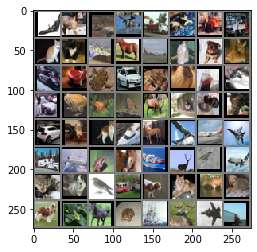

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# Model Summary


In [0]:
from vision.models.resnet import ResNet18

try:
  from torchsummary import summary
except:
  !pip install torchsummary
  from torchsummary import summary

In [9]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = ResNet18().to(device)
summary(model, input_size=(3,32,32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

# Train and Evaluate Model

In [10]:
from vision.train.train_evaluate import Train
import torch.nn as nn
import torch.optim as optim

CUDA Available? True


## Initialising and setting hyper-parameters


In [0]:
EPOCHS = 20
learning_rate = 0.01
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = ResNet18().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
scheduler =None
# scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=EPOCHS)


## Creating Config for Training 

In [0]:
config_list ={
    "device": device,
    "model": model,
    "EPOCHS": EPOCHS,
    "criterion": criterion,
    "optimizer": optimizer,
    "scheduler": scheduler,
    "logger": None,
    "train_loader": train_loader,
    "test_loader" : test_loader,
    "flag_misclassified_images": False
}

## Create obj of Train and run for training


In [13]:
cifar_model_train = Train(config_list)
cifar_model_train.run_model()

  0%|          | 0/782 [00:00<?, ?it/s]

EPOCH:1


Loss=1.4917231798171997 Batch_id=781 Accuracy=45.75: 100%|██████████| 782/782 [00:59<00:00, 13.19it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 5872/10000 (58.72%)

EPOCH:2


Loss=1.0833332538604736 Batch_id=781 Accuracy=66.02: 100%|██████████| 782/782 [00:59<00:00, 13.20it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 6470/10000 (64.70%)

EPOCH:3


Loss=0.6355912685394287 Batch_id=781 Accuracy=74.73: 100%|██████████| 782/782 [00:59<00:00, 13.15it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0121, Accuracy: 7416/10000 (74.16%)

EPOCH:4


Loss=0.6165198683738708 Batch_id=781 Accuracy=79.03: 100%|██████████| 782/782 [00:59<00:00, 13.12it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0106, Accuracy: 7797/10000 (77.97%)

EPOCH:5


Loss=0.43528085947036743 Batch_id=781 Accuracy=81.83: 100%|██████████| 782/782 [00:59<00:00, 13.05it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0089, Accuracy: 8125/10000 (81.25%)

EPOCH:6


Loss=0.2858262360095978 Batch_id=781 Accuracy=83.88: 100%|██████████| 782/782 [00:59<00:00, 13.17it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0080, Accuracy: 8293/10000 (82.93%)

EPOCH:7


Loss=0.4293438196182251 Batch_id=781 Accuracy=85.35: 100%|██████████| 782/782 [00:59<00:00, 13.11it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0075, Accuracy: 8480/10000 (84.80%)

EPOCH:8


Loss=0.2578005790710449 Batch_id=781 Accuracy=86.47: 100%|██████████| 782/782 [00:59<00:00, 13.11it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0077, Accuracy: 8375/10000 (83.75%)

EPOCH:9


Loss=0.4106229841709137 Batch_id=781 Accuracy=87.77: 100%|██████████| 782/782 [00:59<00:00, 13.07it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0071, Accuracy: 8499/10000 (84.99%)

EPOCH:10


Loss=0.4888429045677185 Batch_id=781 Accuracy=88.53: 100%|██████████| 782/782 [00:59<00:00, 13.05it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0072, Accuracy: 8505/10000 (85.05%)

EPOCH:11


Loss=0.21125265955924988 Batch_id=781 Accuracy=89.60: 100%|██████████| 782/782 [00:59<00:00, 13.06it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0066, Accuracy: 8647/10000 (86.47%)

EPOCH:12


Loss=0.08695840835571289 Batch_id=781 Accuracy=90.18: 100%|██████████| 782/782 [00:59<00:00, 13.06it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0059, Accuracy: 8754/10000 (87.54%)

EPOCH:13


Loss=0.5280701518058777 Batch_id=781 Accuracy=91.07: 100%|██████████| 782/782 [00:59<00:00, 13.08it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0071, Accuracy: 8581/10000 (85.81%)

EPOCH:14


Loss=0.2650567591190338 Batch_id=781 Accuracy=91.34: 100%|██████████| 782/782 [00:59<00:00, 13.12it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0066, Accuracy: 8715/10000 (87.15%)

EPOCH:15


Loss=0.7018898725509644 Batch_id=781 Accuracy=91.94: 100%|██████████| 782/782 [00:59<00:00, 13.07it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0061, Accuracy: 8774/10000 (87.74%)

EPOCH:16


Loss=0.033365488052368164 Batch_id=781 Accuracy=92.37: 100%|██████████| 782/782 [00:59<00:00, 13.06it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0062, Accuracy: 8784/10000 (87.84%)

EPOCH:17


Loss=0.1406647264957428 Batch_id=781 Accuracy=92.97: 100%|██████████| 782/782 [00:59<00:00, 13.14it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0056, Accuracy: 8918/10000 (89.18%)

EPOCH:18


Loss=0.02803167700767517 Batch_id=781 Accuracy=93.24: 100%|██████████| 782/782 [00:59<00:00, 13.05it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0052, Accuracy: 8964/10000 (89.64%)

EPOCH:19


Loss=0.057858824729919434 Batch_id=781 Accuracy=93.76: 100%|██████████| 782/782 [00:59<00:00, 13.09it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0052, Accuracy: 8992/10000 (89.92%)

EPOCH:20


Loss=0.3272002935409546 Batch_id=781 Accuracy=94.15: 100%|██████████| 782/782 [00:59<00:00, 13.10it/s]



Test set: Average loss: 0.0058, Accuracy: 8937/10000 (89.37%)



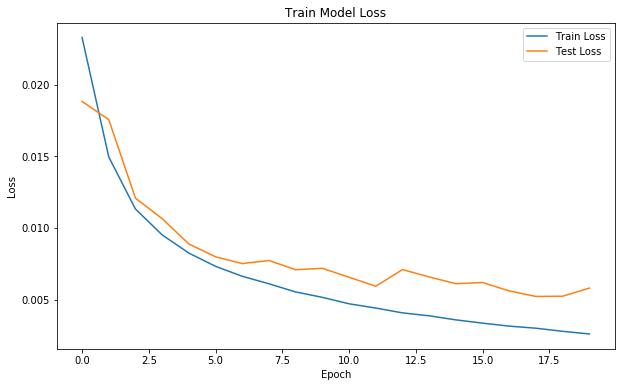

In [14]:
cifar_model_train.plot_loss_graph()

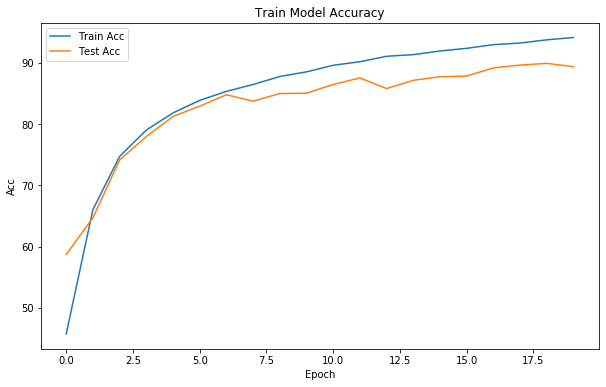

In [15]:
cifar_model_train.plot_acc_graph()

In [0]:
%matplotlib inline